In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# LUCRO
O objetivo é encontrar os parâmetros necessários para se obter o lucro máximo em certos produtos do restaurante, o lucro é definido por

$$L(p, q) = \text{Receita} - \text{Custo}$$

Como a receita é dada pelo produto do preço vendido e a quantidade vendida, pode-se reduzir a formula a:

$$L(p, q) = R(p, q) - C_V - C_F$$

$$L(p, q) = p \cdot q - q \cdot C_{VI} - C_{FI}$$

Onde $C_{VI}$ é o custo variável daquele produto e $C_{FI}$ é o custo fixo individual daquele produto, ou seja, a parcela dos custos fixos que aquele produto deve cobrir com base nas suas vendas. 


In [141]:
desiredProduct = 'Hambúrguer'
pd.ExcelFile('Products.xlsx').sheet_names

['CustosVariaveis', 'CustosFixos', 'Pratos', 'CustosExtras', 'Vendas']

### ENCONTRANDO O PRODUTO DESEJADO

In [142]:
plate_df = pd.read_excel('Products.xlsx', 'Pratos')
plate_df.head()

,Nome do Prato,Ingredientes
0,Pizza,"[{""ingrediente"": ""Massa de Pizza"", ""Quantidade..."
1,Hambúrguer,"[{""ingrediente"": ""Carne"", ""Quantidade Comprada..."
2,Salada Caesar,"[{""ingrediente"": ""Alface"", ""Quantidade Comprad..."
3,Frango Assado,"[{""ingrediente"": ""Frango"", ""Quantidade Comprad..."
4,Risoto de Camarão,"[{""ingrediente"": ""Arroz"", ""Quantidade Comprada..."


In [143]:
target = plate_df[plate_df['Nome do Prato'] == desiredProduct].iloc[0]
target

Nome do Prato                                           Hambúrguer
Ingredientes     [{"ingrediente": "Carne", "Quantidade Comprada...
Name: 1, dtype: object

In [144]:
ingredientsInfo = pd.DataFrame(json.loads(target['Ingredientes']))
ingredientsInfo.rename(columns={'ingrediente': 'Nome'}, inplace=True)

ingredientsInfo

,Nome,Quantidade Comprada,Volume Produzido
0,Carne,2.5,20
1,Pão,20.0,20
2,Alface,2.0,20
3,Tomates,1.0,20
4,Queijo,0.5,20


- A nova coluna mostra a quantidade daquele ingrediente necessária para fazer aquele prato, por exemplo, são necessários 0.125 kg de carne para fazer 1 unidade daquele prato

In [145]:
ingredientsInfo['Quantidade/Unidade'] = ingredientsInfo['Quantidade Comprada']/ingredientsInfo['Volume Produzido']
ingredientsInfo

,Nome,Quantidade Comprada,Volume Produzido,Quantidade/Unidade
0,Carne,2.5,20,0.125
1,Pão,20.0,20,1.000
2,Alface,2.0,20,0.100
3,Tomates,1.0,20,0.050
4,Queijo,0.5,20,0.025


### ENCONTRANDO OS CUSTOS VARIÁVEIS

In [146]:
ingredients_df = pd.read_excel('Products.xlsx', 'CustosVariaveis')
ingredients_df.head()

,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$)
0,Carne,10,kg,300
1,Batatas,20,kg,60
2,Tomates,15,kg,45
3,Queijo,5,kg,80
4,Frango,10,kg,120


- Encontrando o custo variável unitário, ou seja, o preço necessário para comprar 1 unidade do ingrediente

In [147]:
ingredients_df['Custo Variável (R$)'] = ingredients_df['Custo Total (R$)']/ingredients_df['Quantidade Comprada']
ingredients_df.head()

,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$),Custo Variável (R$)
0,Carne,10,kg,300,30.0
1,Batatas,20,kg,60,3.0
2,Tomates,15,kg,45,3.0
3,Queijo,5,kg,80,16.0
4,Frango,10,kg,120,12.0


In [148]:
desiredIngredients = ingredientsInfo['Nome'].tolist()
print(desiredIngredients)

target = ingredients_df.loc[ingredients_df['Nome'].isin(desiredIngredients)]
target

['Carne', 'Pão', 'Alface', 'Tomates', 'Queijo']


,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$),Custo Variável (R$)
0,Carne,10,kg,300,30.0
2,Tomates,15,kg,45,3.0
3,Queijo,5,kg,80,16.0
5,Alface,10,unidades,30,3.0
6,Pão,50,unidades,50,1.0


In [149]:
target = pd.merge(target, ingredientsInfo[['Nome', 'Quantidade/Unidade']], on='Nome')
target

,Nome,Quantidade Comprada,Unidade de Medida,Custo Total (R$),Custo Variável (R$),Quantidade/Unidade
0,Carne,10,kg,300,30.0,0.125
1,Tomates,15,kg,45,3.0,0.050
2,Queijo,5,kg,80,16.0,0.025
3,Alface,10,unidades,30,3.0,0.100
4,Pão,50,unidades,50,1.0,1.000


- O custo variável vai ser a soma de todos os custos variáveis individuais, ou seja, necessários para fazer 1 unidade daquele item

In [150]:
custoVariavel = (target['Custo Variável (R$)'] * target['Quantidade/Unidade']).sum()
custoVariavel

5.6

### ENCONTRANDO OS CUSTOS FIXOS

In [151]:
fix_df = pd.read_excel('Products.xlsx', 'CustosFixos')
fix_df.head()

,Descrição do Custo Fixo,Valor Mensal (R$)
0,Aluguel do Espaço,2000
1,Salários dos Funcionários (incluindo encargos),4000
2,Seguro,100
3,Conta de Energia Elétrica,800
4,Conta de Água,400


In [152]:
custoFixoTotal = fix_df['Valor Mensal (R$)'].sum()
custoFixoTotal

9950

- Agora precisamos dividir os custos totais entre os produtos (pratos) para encontrarmos o preço que cada 1 deve ter. 

- Uma abordagem é dividir os custos fixos proporcionalmente com base na receita ou no volume de vendas de cada produto.

- Ex: Se um produto representa 30% da receita total, ele seria alocado com 30% dos custos fixos. Para fazer isso, vamos usar uma pequena amostra de vendas anteriores

In [153]:
sales_df = pd.read_excel('Products.xlsx', sheet_name='Vendas')
sales_df.head()

,Nome do Prato,Preço Vendido (R$),Data da Venda,Hora da Venda
0,Pizza,30,2024-01-03,19:00:00
1,Salada Caesar,28,2024-01-03,19:30:00
2,Pizza,28,2024-01-03,19:45:00
3,Risoto de Camarão,40,2024-01-03,20:00:00
4,Hambúrguer,22,2024-01-03,20:15:00


In [154]:
totalIncome  = sales_df['Preço Vendido (R$)'].sum()
targetIncome = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]['Preço Vendido (R$)'].sum()

percentageIncome = targetIncome/totalIncome
percentageIncome

0.10835058661145618

- Isso significa que 11% da receita total do restaurante vem desse prato, então o custo fixo para esse prato deve ser 11% do custo fixo total

In [155]:
custoFixo = custoFixoTotal*percentageIncome
custoFixo

1078.088336783989

### PONTO DE EQUILÍBRIO (BREAK POINT)
- O ponto de equilíbrio ocorre quando o total de receitas iguala o total de custos (fixos e variáveis), o que significa que não há lucro nem prejuízo. Ou seja, significa que $L(p, q) = 0$

$$0 = p\cdot q - q \cdot C_V - C_{F}$$

$$q = \frac{C_F}{p - C_V}$$

- Para encontrar o preço do produto $p$, vamos considerar a média dos preços já vendidos, ou o preço de mercado caso não tenha vendido ainda

In [156]:
p = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]['Preço Vendido (R$)'].max()
p

22

In [157]:
def qBreakpoint(p, Cv, Cf):
    return Cf / (p - Cv)

qBreakpoint(p, custoVariavel, custoFixo)

65.7370937063408

- Ou seja, precisamos vender no mínimo $q=66$ unidades ao preço de $p=22$ para obter algum lucro

### ELASTICIDADE PREÇO DA DEMANDA
- A elasticidade-preço da demanda $\epsilon$ é uma medida que indica como a quantidade demandada de um produto ou serviço responde a mudanças no preço.

$$\epsilon = \frac{\triangle Q \%}{\triangle P \%} = \frac{\frac{Q-Q_0}{Q_0}}{\frac{P-P_0}{P_0}}$$

- Onde $Q$ e $Q_0$ são respectivamente a quantidade inicial e final vendidas a partir de uma variação de preço de $P_0$ para $P$

- Quando $|\epsilon| > 1$, a demanda é elástica, ou seja, o produto é sensível à variações de preço, e se eu aumentar um pouquinho o preço, isso irá refletir em menos pessoas comprando o produto, e portanto, uma arrecadação menor na receita. Se for menor do que 1, a demanda é inelástica, ou seja, posso aumentar mais o preço que as pessoas não vão deixar de comprar (significativamente)


In [158]:
target = sales_df.loc[sales_df['Nome do Prato'] == desiredProduct]
target.head()

,Nome do Prato,Preço Vendido (R$),Data da Venda,Hora da Venda
4,Hambúrguer,22,2024-01-03,20:15:00
13,Hambúrguer,22,2024-01-05,19:30:00
20,Hambúrguer,20,2024-01-06,13:00:00
25,Hambúrguer,20,2024-01-06,18:45:00
30,Hambúrguer,20,2024-01-03,19:15:00


In [159]:
P0 = target['Preço Vendido (R$)'].min()
P  = target['Preço Vendido (R$)'].max()

Q0 = (target['Preço Vendido (R$)'] == P0).sum()
Q = (target['Preço Vendido (R$)'] == P).sum()

In [160]:
(P0, Q0, P, Q)

(20, 8, 22, 7)

In [161]:
e =  ((Q-Q0)/Q0) / ((P-P0)/P0)
e

-1.25

- Então temos que a demanda desse produto é elástica, não podemos aumentar o preço, deixa em 20 mermo que ta bom

$\epsilon = \bigg(\frac{\frac{Q-Q_0}{Q_0}}{\frac{P-P_0}{P_0}}\bigg)$

$Q = Q_0 + \epsilon \cdot Q_0 \cdot \bigg(\frac{P - P_0}{P_0}\bigg) = Q_0 \cdot \bigg(1 + \epsilon\,\frac{P - P_0}{P_0}\bigg)$

In [162]:
(Q0, P0, e)

(8, 20, -1.25)

### ENCONTRANDO O LUCRO MÁXIMO

$$\text{Lucro} = \text{Receita} - \text{Custos Variáveis} - \text{Custos Fixos}$$
$$L(p, q) = p\cdot q - q\cdot C_{VI} - C_{FI}$$

Onde $q$ é a quantidade vendida, $p$ é o preço de venda, $C_{VI}$ é o custo variável individual de cada produto e $C_{FI}$ é o custo fixo que os produtos vendidos devem cobrir

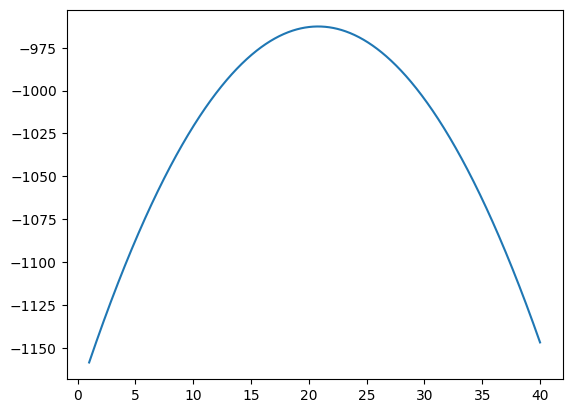

In [163]:
def Q(p, q0, p0, e):
    return q0 * (1 + e * (p - p0)/p0)

def L(p, custoVariavel, custoFixo):
    q = Q(p, Q0, P0, e)
    return (p*q) - (q*custoVariavel) - custoFixo

x = np.linspace(1, 40, 1000)
y = L(x, custoVariavel, custoFixo)

plt.plot(x, y)
plt.show()

In [164]:
lucroMaximo = max(y)
quantidade  = x[y == lucroMaximo]

lucroMaximo, quantidade

(-962.5683627559068, array([20.79279279]))

- Isso faz sentido? o lucro máximo está dando negativo

Sim, como calculamos anteriormente, precisariamos vender $q=66$ unidades desse produto a $p=22$ reais para ter um lucro positivo. Entretanto, pelo comportamento observado na elasticidade-demanda, conforme vamos aumentando o peço as pessoas vão parando de comprar e a quantidade $q$ diminiu. De forma que nunca vamos conseguir vender $q=66$ com $p=22$, já que nesse preço, a quantidade máxima comprada seria de:

In [165]:
Q(22, Q0, P0, e)

7.0

E isso não é 22, que é o mínimo para ter lucro. Ou seja, esse produto nunca vai dar lucro, pare de vendê-lo

### CUSTO MARGINAL
- Aumentar a produção de certo produto irá também aumentar o custo para produzi-lo, mas nem sempre essa relação é linear, o que significa que talvez o custo aumente muito para um pequeno aumento na quantidade produzido, afetando negativamente o lucro. 

- Os custos que podem aumentar são, por exemplo, contas de luz, contas de água, máquinário novo, novos funcionários, ETC. Todos esses novos custos foram inclusos na coluna de "Custo Extra", como mostrado abaixo

- O custo marginal é definido como a variação no custo variável
total devido à produção de uma unidade adicional de produto. Ex.: Um agricultor
que deseje aumentar em uma tonelada a produção de milho por hectare e, para
tanto, utilize uma combinação de fertilizantes. Nesse caso, o custo marginal de
uma tonelada a mais de produto é medido pelo acréscimo no custo variável total
(ou no custo total, se considerarmos que no curto prazo a área da propriedade
não pode ser alterada e que não é possível adquirir novos equipamentos).

$$C_M = \frac{\text{Custo Variável Total}}{\text{Variação na Produção}} = \frac{\triangle C_{VT}}{\triangle q}$$

In [166]:
extra_expenses = pd.read_excel('Products.xlsx', sheet_name='CustosExtras')
extra_expenses.head()

,Nome do Prato,Quantidade Produzida,Custos Extras (R$)
0,Pizza,100,0
1,Hambúrguer,100,0
2,Salada Caesar,100,0
3,Frango Assado,100,0
4,Risoto de Camarão,100,0


In [167]:
target = extra_expenses.loc[extra_expenses['Nome do Prato'] == desiredProduct]
target

,Nome do Prato,Quantidade Produzida,Custos Extras (R$)
1,Hambúrguer,100,0
14,Hambúrguer,300,300


- Como pode-ser observar, o custo aumentou em 300 reais quando a quantidade de Hamburguer aumentou em 200, além dos custos de compra dos alimentos que aumenta linearmente

In [168]:
inicial = target.iloc[0].to_dict()
final   = target.iloc[1].to_dict()

In [169]:
q0 = inicial['Quantidade Produzida']
q  = final['Quantidade Produzida']

c0 = custoVariavel*q0 + inicial['Custos Extras (R$)']
c  = custoVariavel*q + final['Custos Extras (R$)']

q0, q, c0, c

(100, 300, 560.0, 1980.0)

In [170]:
custoMarginal = (c-c0)/(q-q0)
custoMarginal

7.1

### RECEITA MARGINAL
A receita marginal é o aumento na receita total que resulta da venda de uma unidade adicional de um produto ou serviço. É um conceito central na análise de decisões de produção e precificação. 

$$R_M = \frac{\triangle R_T}{\triangle q} = \frac{p\,q - p_0\,q_0}{q-q_0}$$

O preço incial pode ser seu preço atual de venda, e você quer ver como pode aumentar seu lucro a partir dele

In [171]:
p0 = P
p0

22

### LUCRO MÁXIMO
Assumindo o cenário em que seu produto está no $P_0 = $ preço de mercado e em concorrência perfeita. O lucro é maximizado no ponto em que o custo marginal é igual à receita marginal 

$$C_M = R_M$$

$$C_M = \frac{p\,q - p_0\,q_0}{q-q_0}$$

$$p = \frac{1}{q}\big[C_M \, (q-q_0) + p_0\,q_0\big]$$

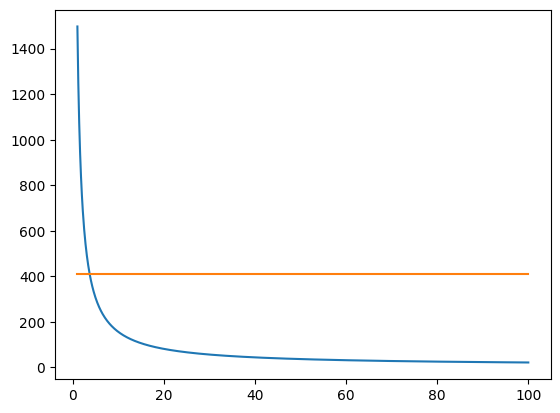

In [172]:
def P(q, q0, p0, custoMarginal):
    return 1/q * (custoMarginal * (q - q0) + p0*q0)

def L(p, q, custoFixo, custoMarginal):
    return p*q - custoMarginal*q - custoFixo

x = np.linspace(1, 100, 1000)
y = P(x, q0, p0, custoMarginal)

plt.plot(x, y)
plt.plot(x, L(y, x, custoFixo, custoMarginal))

In [173]:
pMin = min(y)
qMin = x[y == pMin]

qMin, pMin

(array([100.]), 22.0)